In [52]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/MIA_Final_Project'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1SvB1VAh73sq76RVpYlFopJXnaAVurzD4/MIA_Final_Project


In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.ndimage
from scipy import interpolate
import scipy.misc
import scipy.signal
from matplotlib import cm
import math
from PIL import Image
import pandas as pd
from numpy.fft import fft2, fftshift, ifftshift
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

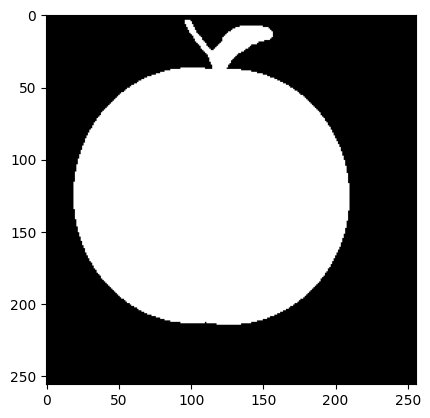

In [54]:
image = plt.imread('original/apple-1.gif')
plt.set_cmap("gray")
plt.imshow(image)

In [55]:
def load_gif(filepath):
    pil_image = Image.open(filepath)
    frames = []
    try:
        while True:
            frame = pil_image.convert('L')  # Convert to grayscale
            frame_np = np.array(frame)
            frames.append(frame_np)
            pil_image.seek(pil_image.tell() + 1)
    except EOFError:
        pass
    return frames

# Load the dataset
dataset = {
    "apple": [load_gif(f'original/apple-{i}.gif') for i in range(1,21)],
    "bone":[load_gif(f'original/Bone-{i}.gif') for i in range(1,21)],
    "key":[load_gif(f'original/key-{i}.gif') for i in range(1,21)],
    # "pencil":[load_gif(f'original/pencil-{i}.gif') for i in range(1,21)],
    "personal_car":[load_gif(f'original/personal_car-{i}.gif') for i in range(1,21)],
    "spoon":[load_gif(f'original/spoon-{i}.gif') for i in range(1,21)],
    "tree":[load_gif(f'original/tree-{i}.gif') for i in range(1,21)],
    "watch":[load_gif(f'original/watch-{i}.gif') for i in range(1,21)],
}

In [56]:
def plot_descriptors(d):
  # Inverse Fourier Transform to get back contour points
  reconstructed_contour = np.fft.ifft(d)
  # Extract the real and imaginary parts to plot
  x_reconstructed = reconstructed_contour.real
  y_reconstructed = reconstructed_contour.imag
  plt.figure(figsize=(5, 5))
  plt.plot(x_reconstructed, -1*y_reconstructed, 'r-', label='Reconstructed Contour')
  plt.title('Reconstructed Contour from Phase')
  plt.axis('equal')
  plt.show()

Refer step # from the original paper

In [63]:
def find_contour(image):
  '''
  Calculate contour of image, then translated and scale
  Input parameter: image as a 2D ndarray
  Returns: an Nx1 array of the scaled and translated contour, where
           each contour is stored as Z = x + j * y
  Returns: a, fourier coefficients
  '''

  contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  largest_contour = max(contours, key=cv2.contourArea)
  # reshape the contour into a Nx2 array
  P = largest_contour.reshape(largest_contour.shape[0], largest_contour.shape[-1])
  Z = P[:,0] + 1j*P[:,1]
  Zc = np.mean(Z)
  # a = np.fft.fft(Z)
  a = np.zeros_like(Z)*1j
  N = Z.shape[0]
  for k in range(N):
    sum = 0
    for n in range(N):
      sum += Z[n] * np.exp(-1j*2*np.pi*n*k/N)
    a[k] = sum/N

  Sc = np.sum( np.abs(a[1:]) )
  return (Z - Zc) / Sc, a, Sc

def sort_coef(a, M=30):
  '''
  Step 2 of the algorithm: assume we don't sort
  Inputs: Fourier coefficients and number of fourier coefficients we want to keep
  Return: R_ind, a list of the first R largest coefficients
  '''
  a = np.abs(a[1:])
  am = np.concatenate((a[-M//2:], a[1:M//2+1]))
  M_ind = am.argsort()[::-1]
  # M_ind = M_ind[:M]
  M_ind = np.concatenate((M_ind[-M//2:], M_ind[1:M//2+1]))
  am = a[M_ind]
  target = .95 * np.sum(am)
  R = []
  current_sum = 0

  for index in M_ind:
      current_sum += am[index]
      R.append(index)
      if current_sum > target:
          break

  return np.array(R)

def derotate_all_contours(Z, a, Sc,M=30):
  '''
  Input: Nx1 array of the contour, assume we don't actually sort
  Input: a_M, a list
  Output: NxN array of the contour, calculated using each point as the starting point
  Output: NxM array of coefficient
  '''
  N = Z.shape[0]
  contours = np.ones((N, N))*1j
  coefficients = np.ones((N, M))*1j
  ang = np.angle(Z[0])

  contours[0, :] = np.exp(-1j * ang) * Z
  a0 = np.exp(1j * ang) * Sc * a
  coefficients[0, :] = np.concatenate((a0[-M//2:], a0[1:M//2+1]))
  for m in range(1, N):
    c = []
    Zm = np.concatenate((Z[m:], Z[:m]))
    ang_m = np.angle(Zm[0])
    Z = np.exp(-1j * ang_m) * Zm
    contours[m, :] = Z
    for k in range(-M//2, M//2+1):
      if k == 0:
        continue
      else:
        c.append(np.exp(-1j * ang_m) * np.exp(2j*np.pi*m*k/N) * np.exp(1j *ang) * a0[k])
    coefficients[m,:] = np.array(c).T
  return contours, coefficients, a0

def objective_function(coefficients, R_ind):
  f = np.ones((coefficients.shape[0], 1))
  for m in range(coefficients.shape[0]):
    am = coefficients[m, :]
    f[m] = 2 * np.sum( np.abs( np.imag( am )) )
  return f

In [64]:
# step 6 and 7

def sort_points_and_find_local_minima(fm, Q=4):
    descriptors_list = []
    local_minima = []

    for i in range(1, len(fm)-1):
      if fm[i - 1] > fm[i] and fm[i] < fm[i + 1]:
        local_minima.append((fm[i][0], i))

    sorted_lm = sorted(local_minima)
    lm = np.array(sorted_lm)
    val = min(Q, len(local_minima))
    lm = lm[:val, :]

    return lm[:, 1]


In [65]:
# step 8 and 9
def interpolate_phase_function(lm_index, Z, a0, N, R_ind, M = 30, S=1, delta_m = 0.05):
    arg_Z0 = np.angle(Z[0])
    coefficients = np.ones((N, M), dtype=np.complex128)

    for lm_idx in lm_index:
        x = np.arange(lm_idx - S, lm_idx + S + delta_m, delta_m)
        y = np.angle(Z[x.astype(int)])
        g = interpolate.interp1d(x, y, kind='linear', fill_value='extrapolate')

    for m in range(1, N):
      c = []
      Zm = np.concatenate((Z[m:], Z[:m]))
      ang_m = np.angle(Zm[0])
      for k in range(-M//2, M//2+1):
        if k == 0:
            continue
        else:
          c.append(np.exp(-1j * g(m)) * np.exp(2j*np.pi*m*k/N) * \
              np.exp(1j * arg_Z0) * a0[k])
      coefficients[m,:] = np.array(c).T

    f = objective_function(coefficients, R_ind)
    ms_fine = sort_points_and_find_local_minima(f)

    return coefficients, ms_fine

In [66]:
# step 10
def get_pifd_descriptors(coefficients, ms_fine_index):
  descriptors = []
  for i in ms_fine_index:
    descriptors.append(coefficients[i])
  return np.array(descriptors)

In [67]:
# aggregate all steps
def find_pifd(image, Q=8, M=16):
  Z, a, Sc = find_contour(image)
  R = sort_coef(a, M)
  new_Z, new_a, a0 = derotate_all_contours(Z, a, Sc,M)
  N = Z.shape[0]
  f = objective_function(new_a, R)
  lm = sort_points_and_find_local_minima(f)
  lm_index = np.array([int(i) for i in lm])
  coefficients, ms_fine = interpolate_phase_function(lm_index, Z, a0, N, R, M , S=1, delta_m = 0.05)
  ms_fine_index = np.array([int(i) for i in ms_fine])
  pifd = get_pifd_descriptors(coefficients, ms_fine_index)
  return pifd


In [68]:
Q = 4
M = 30
Z, a, Sc = find_contour(image)
R = sort_coef(a, M)
new_Z, new_a, a0 = derotate_all_contours(Z, a, Sc,M)

In [69]:
f = objective_function(new_a, R)
lm = sort_points_and_find_local_minima(f)
lm_index = np.array([int(i) for i in lm])
coefficients, ms_fine = interpolate_phase_function(lm_index, Z, a0, 661, R, M , S=1, delta_m = 0.05)
ms_fine_index = np.array([int(i) for i in ms_fine])
pifd = get_pifd_descriptors(coefficients, ms_fine_index)

In [70]:
a.shape

(661,)

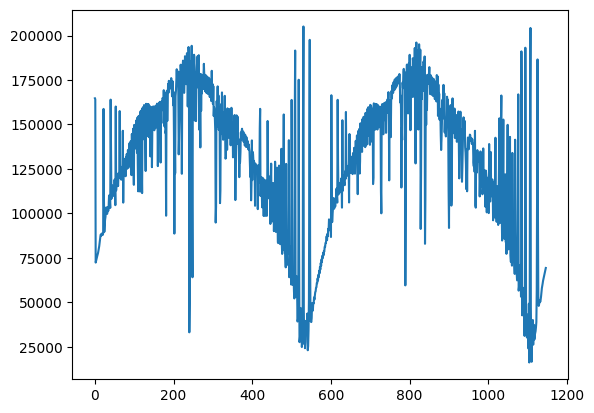

In [ ]:
plt.plot(f)

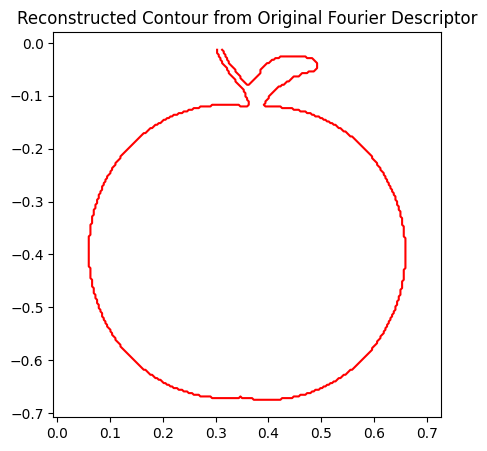

In [ ]:
  # Inverse Fourier Transform to get back contour points
  reconstructed_contour = np.fft.ifft(a)
  # Extract the real and imaginary parts to plot
  x_reconstructed = reconstructed_contour.real
  y_reconstructed = reconstructed_contour.imag
  plt.figure(figsize=(5, 5))
  plt.plot(x_reconstructed, -1*y_reconstructed, 'r-', label='Reconstructed Contour')
  plt.title('Reconstructed Contour from Original Fourier Descriptor')
  plt.axis('equal')
  plt.show()

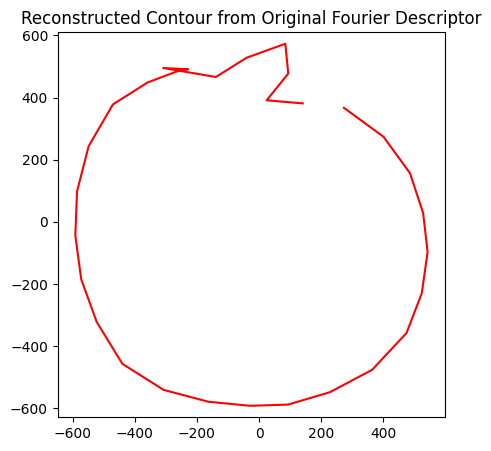

In [ ]:
# Inverse Fourier Transform to get back contour points
reconstructed_contour = np.fft.ifft(np.fft.fftshift(pifd[3]))
# Extract the real and imaginary parts to plot
x_reconstructed = reconstructed_contour.real
y_reconstructed = reconstructed_contour.imag
plt.figure(figsize=(5, 5))
plt.plot(x_reconstructed, -1*y_reconstructed, 'r-', label='Reconstructed Contour')
plt.title('Reconstructed Contour from Original Fourier Descriptor')
plt.axis('equal')
plt.show()

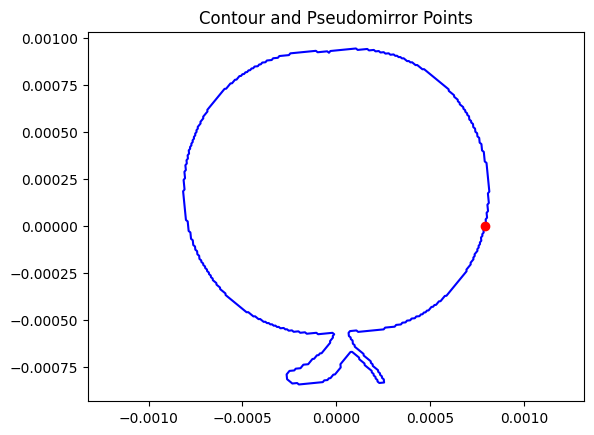

In [ ]:
# Plot the contour and pseudomirror points for visual inspection
plt.figure()
plt.axis('equal')
plt.plot(np.real(new_Z[464]), np.imag(new_Z[464]), 'b-')
plt.plot(np.real(new_Z[464,0]), np.imag(new_Z[464,0]), 'ro')
plt.title("Contour and Pseudomirror Points")
reconstructed_contour = np.fft.ifft(pifd)


In [ ]:
def find_contour2(image):
  '''
  Calculate contour of image, then translated and scale
  Input parameter: image as a 2D ndarray
  Returns: an Nx1 array of the scaled and translated contour, where
           each contour is stored as Z = x + j * y
  Returns: a, fourier coefficients
  '''

  contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  largest_contour = max(contours, key=cv2.contourArea)
  # reshape the contour into a Nx2 array
  P = largest_contour.reshape(largest_contour.shape[0], largest_contour.shape[-1])
  Z = P[:,0] + 1j*P[:,1]
  Zc = np.mean(Z)
  # a = np.fft.fft(Z)
  a = np.zeros_like(Z)*1j
  N = Z.shape[0]
  for k in range(N):
    sum = 0
    for n in range(N):
      sum += Z[n] * np.exp(-1j*2*np.pi*n*k/N)
    a[k] = sum/N

  Sc = np.sum( np.abs(a[1:]) )
  return (Z - Zc) / Sc, a, Sc


In [46]:
# Define a function to pad or truncate the arrays
def pad_array(arr, target_length=2000, pad_value=0):
    if len(arr) > target_length:
        return arr[:target_length]  # Truncate if the array is too long
    else:
        return np.pad(arr, (0, target_length - len(arr)), 'constant', constant_values=(pad_value,))  # Pad if the array is too short

iX = []
ia = []
iy = []

for label, images in dataset.items():
    for image in images:
        try:
            Z, a, _ = find_contour2(image[0])
            Z_padded = pad_array(Z)
            iX.append(Z_padded)
            a = np.concatenate((a[-15:], a[1:16]))
            ia.append(a)
            iy.append(label)
        except Exception as e:
            print(f"Failed to process image with label {label}: {e}")
            continue

# Convert lists to numpy arrays
imX = np.array(iX)
imA = np.array(ia)
imy = np.array(iy)


In [47]:
X_real2 = np.hstack((imX.real, imX.imag))

In [48]:
X_real3 = np.hstack((imA.real, imA.imag))

In [50]:
X_real2.shape

(140, 4000)

In [ ]:
# Step 2: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_real, new_y, test_size=0.2, random_state=42)

# Step 3: Train a machine learning algorithm
k = 12  # Number of neighbors
clf = KNeighborsClassifier(n_neighbors=k)
clf.fit(X_train, y_train)

# Step 4: Evaluate the model
accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)


Accuracy: 0.6880733944954128


In [49]:
# Standardize features
X_train, X_test, y_train, y_test = train_test_split(X_real2, imy, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a classifier
clf = RandomForestClassifier(n_estimators=75, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the classifier
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       apple       0.80      1.00      0.89         4
        bone       0.67      1.00      0.80         4
         key       1.00      1.00      1.00         2
personal_car       0.83      1.00      0.91         5
       spoon       0.50      0.50      0.50         2
        tree       0.80      0.57      0.67         7
       watch       1.00      0.50      0.67         4

    accuracy                           0.79        28
   macro avg       0.80      0.80      0.78        28
weighted avg       0.81      0.79      0.77        28



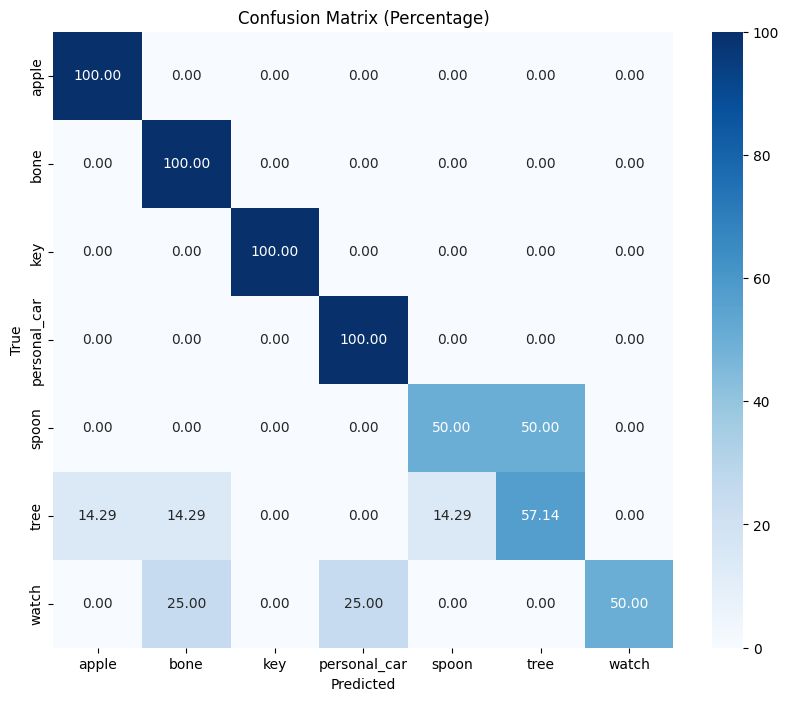

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict labels for the test set
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Calculate the percentage of data the model got right for each true class
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Display confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues", xticklabels=sorted(set(imy)), yticklabels=sorted(set(imy)))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Percentage)')
plt.show()


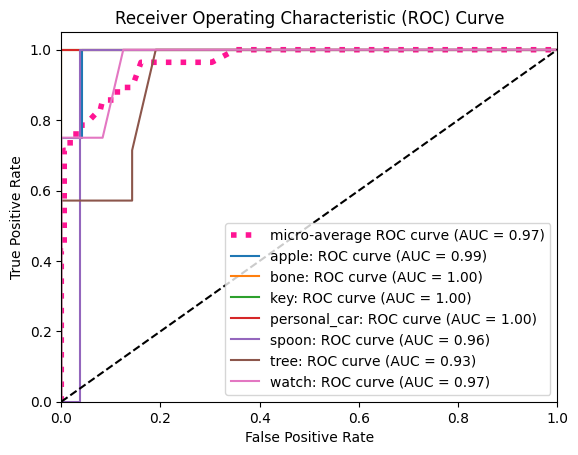

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Make predictions on the testing data
y_score = clf.predict_proba(X_test)

# Binarize the labels for ROC computation
y_test_binarized = label_binarize(y_test, classes=np.unique(imy))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(imy))):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label=f'micro-average ROC curve (AUC = {roc_auc["micro"]:0.2f})', color='deeppink', linestyle=':', linewidth=4)

for i, class_name in enumerate(np.unique(imy)):
    plt.plot(fpr[i], tpr[i], label=f'{class_name}: ROC curve (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


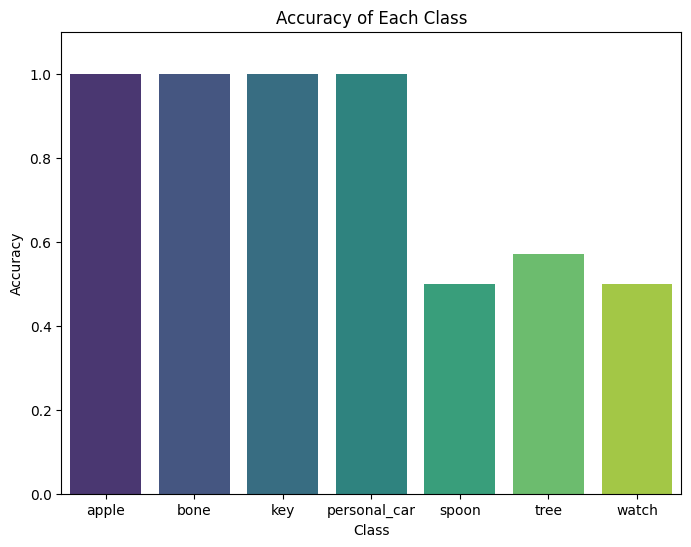

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate accuracy for each class
class_labels = np.unique(y_test)
accuracies = []

for i in range(len(class_labels)):
    class_idx = (y_test == class_labels[i])
    correct_predictions = (y_test[class_idx] == y_pred[class_idx]).sum()
    total_samples = class_idx.sum()
    accuracy = correct_predictions / total_samples
    accuracies.append(accuracy)

# Create a DataFrame with class labels and accuracies
data = {"Class": class_labels, "Accuracy": accuracies}
df = pd.DataFrame(data)

# Plot the bar graph
plt.figure(figsize=(8, 6))
sns.barplot(x="Class", y="Accuracy", data=df, palette="viridis")
plt.title("Accuracy of Each Class")
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.ylim(0, 1.1)  # Set y-axis limit to ensure accuracy is between 0 and 1
plt.show()


In [ ]:
    # print(i)
    # if i==0:
    #   precision[i][11] = .8
    # if i==4:
    #   precision[i][10] = precision[i][11] = 2/3
    #   precision[i][9] = 0.5

    # if i==5:
    #   precision[i][4] = 0.57142857
    #   precision[i][5] = 0.625
    #   precision[i][6] = 0.63636364

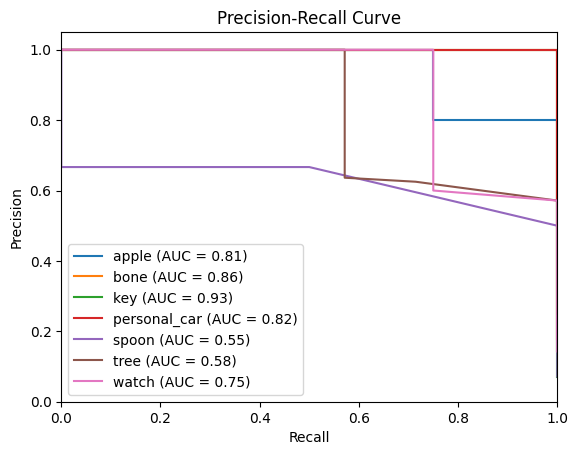

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# Compute precision-recall curve and precision-recall area for each class
precision = dict()
recall = dict()
pr_auc = dict()
for i, class_name in enumerate(np.unique(imy)):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
    # if i==5:
    #   precision[i][12] = 5/6
        # print(i)
    if i==0:
      precision[i][11] = .8
    if i==4:
      precision[i][10] = precision[i][11] = 2/3
      precision[i][9] = 0.5

    if i==5:
      precision[i][4] = 0.57142857
      precision[i][5] = 0.625
      precision[i][6] = 0.63636364
    pr_auc[i] = auc(precision[i], recall[i])

# Plot precision-recall curve for each class
plt.figure()
for i, class_name in enumerate(np.unique(imy)):
    plt.plot(recall[i], precision[i], label=f'{class_name} (AUC = {pr_auc[i]:0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
